This notebook is to test the `OPTIMIZED` transformer training and validation task for language translation
* https://towardsdatascience.com/optimize-pytorch-performance-for-speed-and-memory-efficiency-2022-84f453916ea6

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/EraV2_Transformers"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/EraV2_Transformers


In [3]:
from S18_code.config import get_config, get_weights_file_path
from S18_code.model import build_transformer
import torch
from S18_code.dataloader import get_ds
from datasets import load_dataset
import torch.optim as optim
import torch.nn as nn

In [4]:
device = get_config()["device"]
print(device)

cuda


In [5]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())
print(torch.cuda.get_device_name(device.index))
print(torch.cuda.get_device_properties(device.index).total_memory / 1024**3)
print(torch.cuda.memory_summary(device=device.index))
print(torch.cuda.get_device_capability(device.index))
print(torch.cuda.get_device_properties(device.index))

True
0
Tesla V100-PCIE-16GB
0
0
Tesla V100-PCIE-16GB
15.7725830078125
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 

In [6]:
ds_raw = load_dataset(
    get_config()["datasource"],
    f"{get_config()['src_lang']}-{get_config()['tgt_lang']}",
    split="train",
)
print(len(ds_raw))

32332


In [7]:
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(
    ds_raw, get_config()
)

Building tokenizer for en
Tokenizer for en already exists


Building tokenizer for it
Tokenizer for it already exists


In [8]:
for data in train_dataloader:
    print(data["encoder_input"].shape)
    print(data["decoder_input"].shape)
    print(data["encoder_mask"].shape)
    print(data["decoder_mask"].shape)
    break

torch.Size([16, 44])
torch.Size([16, 39])
torch.Size([16, 1, 1, 44])
torch.Size([16, 1, 39, 39])


In [9]:
for data in val_dataloader:
    print(data["encoder_input"].shape)
    print(data["decoder_input"].shape)
    print(data["encoder_mask"].shape)
    print(data["decoder_mask"].shape)
    break

torch.Size([1, 8])
torch.Size([1, 9])
torch.Size([1, 1, 1, 8])
torch.Size([1, 1, 9, 9])


In [10]:
print(tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size())

14554 21401


In [11]:
transformer_model = build_transformer(
    src_vocab_size=tokenizer_src.get_vocab_size(),
    tgt_vocab_size=tokenizer_tgt.get_vocab_size(),
).to(device)

In [12]:
print(torch.cuda.memory_summary(device=device.index))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 288888 KiB | 288888 KiB | 288888 KiB |      0 B   |
|       from large pool | 213428 KiB | 213428 KiB | 213428 KiB |      0 B   |
|       from small pool |  75460 KiB |  75460 KiB |  75460 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 288888 KiB | 288888 KiB | 288888 KiB |      0 B   |
|       from large pool | 213428 KiB | 213428 KiB | 213428 KiB |

In [13]:
!nvidia-smi

Fri Jun 14 19:03:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000001:00:00.0 Off |                    0 |
| N/A   26C    P0              38W / 250W |    598MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Training the model

In [14]:
from torch.optim import Adam
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
import torch.nn as nn
import torch
from tqdm import tqdm
from S18_code.dataset import causal_mask

In [15]:
# Optimizer Adam with weight decay
optimizer = Adam(
    transformer_model.parameters(),
    betas=(0.9, 0.98),
    eps=1.0e-9,
    lr=get_config()["learning_rate"],
)

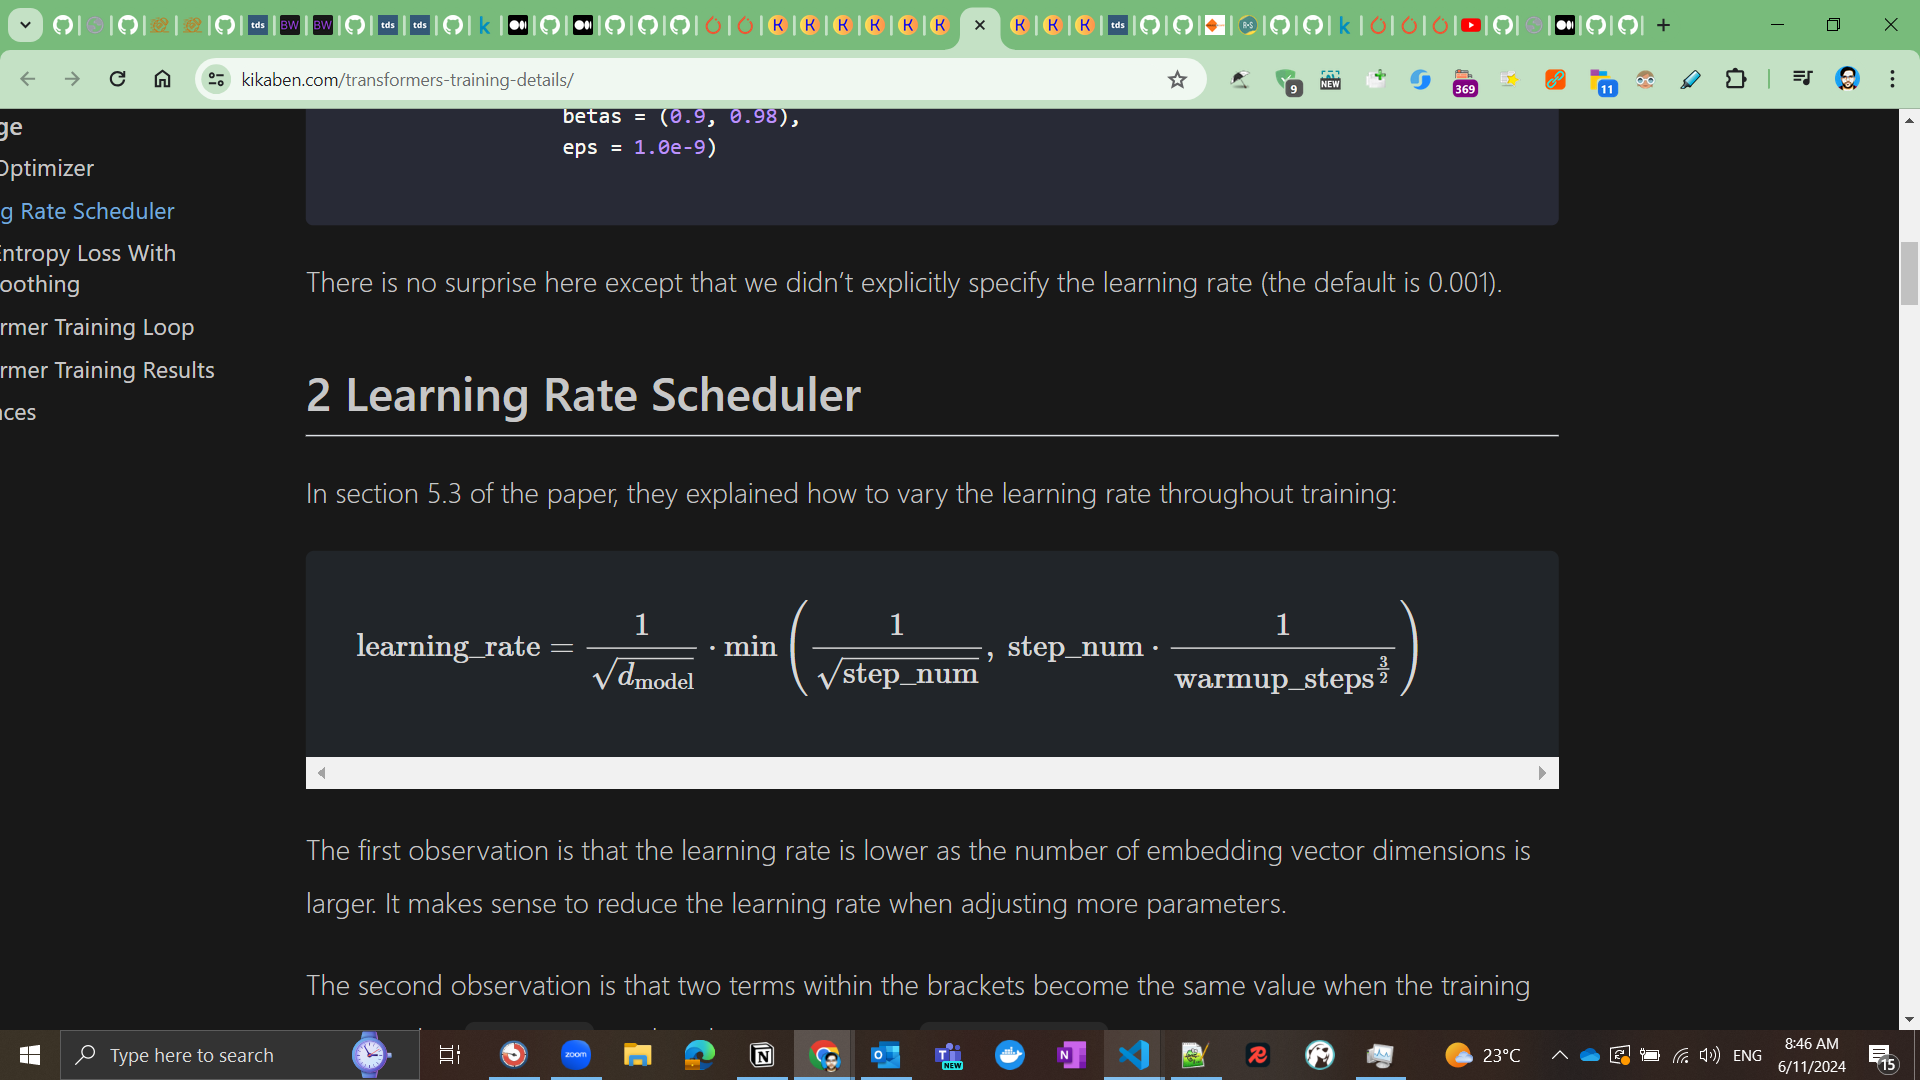

#### Custom LR-Scheduler

In [16]:
# The idea is learning rate should be high initially and then decrease as the training progresses and more the embeddings are learned lower the learning rate should be
def custom_lr(step, dim_embed, warmup_steps):
    """Learning rate schedule as per the paper"""
    lr = (dim_embed**-0.5) * min(step ** (-0.5), step * warmup_steps ** (-1.5))
    return lr

In [17]:
class CustomLRScheduler(_LRScheduler):
    """Custom learning rate scheduler"""

    def __init__(
        self,
        optimizer: Optimizer,
        dim_embed: int,
        warmup_steps: int,
        last_epoch: int = -1,
        verbose: bool = False,
    ) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self) -> float:
        lr = custom_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

In [18]:
scheduler = CustomLRScheduler(optimizer, get_config()["d_model"], 4000)

/anaconda/envs/torch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#### LOSS

In [19]:
pad_idx = tokenizer_src.token_to_id("[PAD]")
sos_idx = tokenizer_src.token_to_id("[SOS]")
eos_idx = tokenizer_src.token_to_id("[EOS]")
label_smoothing = 0.1

In [20]:
# the objective is to predict the next word in the sequence while calculating the loss and ignoring the padding token and adding label smoothing for regularization to prevent overfitting
# criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)

#### Translation loss -  we use the nn.CrossEntropyLoss, we need to flatten the model outputs and label token indices.

In [21]:
class TranslationLoss(nn.Module):
    """Custom loss function for translation task"""

    def __init__(self, pad_idx, label_smoothing, tokenizer_tgt):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(
            ignore_index=pad_idx, label_smoothing=label_smoothing
        )
        self.vocab_size = tokenizer_tgt.get_vocab_size()

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        logits = logits.view(-1, self.vocab_size)
        labels = labels.view(-1).long()
        return self.criterion(logits, labels)

In [22]:
criterion = TranslationLoss(pad_idx, label_smoothing, tokenizer_tgt)

In [23]:
from torchmetrics.text import BLEUScore
metric = BLEUScore()

In [24]:
# def run_training_loop_basic(
#     model, train_dataloader, optimizer, loss_fn, device, global_step, scheduler
# ):
#     """Training loop for the model"""
    
#     # Setting model to train mode
#     model.train()
#     train_batch_writer = tqdm(
#         train_dataloader, total=len(train_dataloader), desc="Training"
#     )
#     total_loss = 0.0
#     num_batches = len(train_dataloader)

#     for batch in train_batch_writer:
#         encoder_input = batch["encoder_input"].to(device)
#         decoder_input = batch["decoder_input"].to(device)
#         encoder_mask = batch["encoder_mask"].to(device)
#         decoder_mask = batch["decoder_mask"].to(device)
#         label = batch["label"].to(device)

#         # Forward pass
#         encoder_output = model.encode(encoder_input, encoder_mask)
#         decoder_output = model.decode(
#             encoder_output, encoder_mask, decoder_input, decoder_mask
#         )
#         projection_output = model.project(decoder_output)

#         # Computing loss between model's output and true labels
#         loss = loss_fn(projection_output, label)

#         total_loss += loss.item()

#         # Updating progress bar
#         train_batch_writer.set_postfix({"loss": f"{loss.item():6.3f}"})

#         loss.backward()

#         # Updating parameters based on the gradients
#         optimizer.step()

#         # Clearing the gradients to prepare for the next batch
#         optimizer.zero_grad(set_to_none=True)

#         global_step += 1
#         # Update learning rate
#         if scheduler is not None:
#             scheduler.step()

#     # average training loss
#     epoch_loss = total_loss / num_batches
#     train_batch_writer.set_postfix(
#         {"Epoch Training loss": f"{epoch_loss:6.3f}"})
#     return epoch_loss, global_step

In [ ]:
def run_training_loop_basic(
    model, train_dataloader, optimizer, loss_fn, device, global_step, scheduler=None
):
    """Training loop for the model"""

    model.train()
    train_batch_writer = tqdm(
        train_dataloader, total=len(train_dataloader), desc="Training"
    )
    total_loss = 0.0
    num_batches = len(train_dataloader)

    for batch in train_batch_writer:
        encoder_input = batch["encoder_input"].to(device, non_blocking=True)
        decoder_input = batch["decoder_input"].to(device, non_blocking=True)
        encoder_mask = batch["encoder_mask"].to(device, non_blocking=True)
        decoder_mask = batch["decoder_mask"].to(device, non_blocking=True)
        label = batch["label"].to(device, non_blocking=True)

        # Forward pass
        optimizer.zero_grad(set_to_none=True)  # Clear gradients before forward pass
        encoder_output = model.encode(encoder_input, encoder_mask)
        decoder_output = model.decode(
            encoder_output, encoder_mask, decoder_input, decoder_mask
        )
        projection_output = model.project(decoder_output)

        # Computing loss between model's output and true labels
        loss = loss_fn(projection_output, label)
        total_loss += loss.item()

        # Updating progress bar
        train_batch_writer.set_postfix({"loss": f"{loss.item():6.3f}"})

        loss.backward()

        # Updating parameters based on the gradients
        optimizer.step()

        global_step += 1

        # Update learning rate
        if scheduler is not None:
            scheduler.step()

    # Average training loss
    epoch_loss = total_loss / num_batches
    train_batch_writer.set_postfix({"Epoch Training loss": f"{epoch_loss:6.3f}"})
    return epoch_loss, global_step

In [25]:
def run_validation_loop(model, val_dataloader, loss_fn, device):
    """Validation loop for the model"""
    # Setting model to evaluation mode
    model.eval()

    # Progress bar for validation loop
    val_batch_writer = tqdm(
        val_dataloader, total=len(val_dataloader), desc="Validation"
    )
    total_loss = 0.0
    num_batches = len(val_dataloader)

    with torch.no_grad():
        for batch in val_batch_writer:
            # all the tensors are moved to the device
            encoder_input = batch["encoder_input"].to(device, non_blocking=True)
            decoder_input = batch["decoder_input"].to(device, non_blocking=True)
            encoder_mask = batch["encoder_mask"].to(device, non_blocking=True)
            decoder_mask = batch["decoder_mask"].to(device, non_blocking=True)
            label = batch["label"].to(device, non_blocking=True)

            # Forward pass without calculating gradients
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(
                encoder_output, encoder_mask, decoder_input, decoder_mask
            )
            projection_output = model.project(decoder_output)

            # Computing loss between model's output and true labels
            loss = loss_fn(projection_output, label)
            total_loss += loss.item()

            val_batch_writer.set_postfix({"loss": f"{loss.item():6.3f}"})

    # average validation loss
    epoch_loss = total_loss / num_batches
    val_batch_writer.set_postfix({"Epoch Validation loss": f"{epoch_loss:6.3f}"})
    return epoch_loss

In [26]:
def greedy_decode(model, enocode, encode_mask, max_len, device, sos_idx, eos_idx):
    
    """Greedy decoding for the model"""
    # encoder_output
    encode_op = model.encode(enocode, encode_mask)

    # sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(enocode).to(device)

    while decoder_input.size(1) < max_len:
        # decoder mask
        decode_mask = causal_mask(decoder_input.size(1)).type_as(encode_mask).to(device)

        # decoder output
        decode_op = model.decode(encode_op, encode_mask, decoder_input, decode_mask)

        # project the output
        projection_op = model.project(decode_op[:, -1])

        # get next token
        _, next_word = torch.max(projection_op, dim=1)

        # append the next word to the decoder input and repeat the process
        decoder_input = torch.cat(
            [
                decoder_input,
                torch.empty(1, 1).type_as(enocode).fill_(next_word.item()).to(device),
            ],
            dim=1,
        )

        # break if eos token is predicted or max_len is reached
        if next_word.item() == eos_idx :
            break

    return decoder_input[:, 1:].squeeze(0)  # remove sos token from beginning

In [27]:
# def run_inference_loop(
#     model, val_dataloader, tokenizer_tgt, device, num_examples, cushion=50
# ):
#     """Inference loop for the model"""

#     # Setting the model to evaluation mode
#     model.eval()
#     count = (
#         0  # Initializing counter to keep track of how many examples have been processed
#     )
#     # Initializing lists to store the source, target, and predicted texts
#     source_texts = []
#     expected = []
#     predicted = []

#     # Initializing the tqdm progress bar
#     val_batch_writer = tqdm(val_dataloader, total=len(val_dataloader), desc="Inference")

#     with torch.no_grad():
#         for batch in val_batch_writer:
#             count += 1
#             encoder_input = batch["encoder_input"].to(device)
#             encoder_mask = batch["encoder_mask"].to(device)

#             # print(encoder_input.shape)
#             # print(encoder_mask.shape)
#             # print(encoder_input)

#             # Setting the maximum length of the output sequence

#             max_len = encoder_input.shape[-1] + cushion

#             # Ensuring that the batch_size of the validation set is 1
#             assert encoder_input.size(0) == 1, "Batch size must be 1 for validation."

#             # Generating the predicted sequence using greedy decoding
#             model_out = greedy_decode(
#                 model,
#                 encoder_input,
#                 encoder_mask,
#                 max_len,
#                 device,
#             )

#             # print(model_out.shape)
#             # print(model_out)

#             # Retrieving source and target texts from the batch
#             source_text = batch["src_texts"][0]
#             target_text = batch["tgt_texts"][0]  # True translation

#             # Decoding the model output
#             model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

#             # Printing results
#             val_batch_writer.write(f"SOURCE: {source_text}")
#             val_batch_writer.write(f"TARGET: {target_text}")
#             val_batch_writer.write(f"PREDICTED: {model_out_text}")

#             # Appending the source, target, and predicted sequences to the respective lists
#             source_texts.append(source_text)
#             expected.append(target_text)
#             predicted.append(model_out_text)

#             acc = metric(expected, predicted)
#             val_batch_writer.write(f"BLEU Score: {acc}")

#             if count == num_examples:
#                 break

#         acc = metric.compute()
#         print(f"BLEU Score: {acc}")
#         metric.reset()

In [ ]:
def run_inference_loop(
    model,
    val_dataloader,
    tokenizer_tgt,
    device,
    num_examples,
    metric,
    sos_idx,
    eos_idx,
    cushion=50,
):
    """Inference loop for the model"""
    # Set the model to evaluation mode
    model.eval()

    # Initialize counters and lists to store results
    count = 0
    source_texts, expected, predicted = [], [], []

    # Initialize tqdm for progress tracking
    val_batch_writer = tqdm(val_dataloader, total=len(val_dataloader), desc="Inference")

    # Disable gradient calculation during inference
    with torch.no_grad():
        for batch in val_batch_writer:
            # Stop iterating if desired number of examples is reached
            if count == num_examples:
                break

            # Move data to the appropriate device
            encoder_input = batch["encoder_input"].to(device, non_blocking=True)
            encoder_mask = batch["encoder_mask"].to(device, non_blocking=True)

            # Calculate maximum length for decoding
            max_len = encoder_input.shape[-1] + cushion

            # Ensure batch size is 1 for validation
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation."

            # Perform greedy decoding to generate the output sequence
            model_out = greedy_decode(
                model, encoder_input, encoder_mask, max_len, device, sos_idx, eos_idx
            )

            # Retrieve source and target texts from the batch
            source_text = batch["src_texts"][0]
            target_text = batch["tgt_texts"][0]

            # Decode the model output to text format
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            # Print the source, target, and predicted texts
            val_batch_writer.write(f"SOURCE: {source_text}")
            val_batch_writer.write(f"TARGET: {target_text}")
            val_batch_writer.write(f"PREDICTED: {model_out_text}")

            # Append source, target, and predicted texts to respective lists
            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Update counter for processed examples
            count += 1

        # Calculate BLEU score for the entire inference process
        acc = metric(expected, predicted)
        print(f"BLEU Score: {acc}")
        metric.reset()  # Reset the metric for future calculations

In [28]:
for epoch in range(2):
    global_step = 0
    train_loss, global_step = run_training_loop(
        transformer_model,
        train_dataloader,
        optimizer,
        criterion,
        device,
        global_step,
        scheduler,
    )
    print(f"Epoch: {epoch}, Train loss: {train_loss}")

    val_loss = run_validation_loop(transformer_model, val_dataloader, criterion, device)
    print(f"Epoch: {epoch}, Validation loss: {val_loss}")

    run_inference_loop(
        transformer_model,
        val_dataloader,
        tokenizer_tgt,
        device,
        5,
        metric,
        sos_idx,
        eos_idx,
    )

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1819/1819 [04:50<00:00,  6.26it/s, loss=6.074]


Epoch: 0, Train loss: 6.713770217067138


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3234/3234 [01:49<00:00, 29.59it/s, loss=6.479]


Epoch: 0, Validation loss: 5.66695972423754


Inference:   0%|▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/3234 [00:01<1:28:45,  1.65s/it]

SOURCE: I know you to be a really high-minded man,' said Betsy, stopping short in the little sitting-room and once again pressing his hand with peculiar warmth. 'I am only an outsider, but am so fond of her and respect you so much that I will take the liberty of advising you.
TARGET: Io vi conosco per un uomo veramente generoso — disse Betsy fermandosi nel piccolo salotto e stringendogli in modo particolarmente forte ancora una volta la mano. — Io sono una persona estranea, ma voglio tanto bene a lei e stimo tanto voi che mi permetto darvi un consiglio.
PREDICTED: — è un ’ è un uomo di un po ’ è un po ’ è un po ’ è un po ’ è un ’ è un po ’ è un ’ è un ’ è un ’ è un ’ è un po ’ è un ’ è un ’ è un ’ è un ’ è un ’ è un ’ è un ’ è un ’ è un ’ è un ’ ja rochester .
BLEU Score: 0.0


Inference:   0%|▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 2/3234 [00:02<54:23,  1.01s/it]

SOURCE: However, do as you like!' and turning away so that his brother-in-law should not see his face, he sat down on a chair by the window.
TARGET: E voltatosi in modo che il cognato non potesse vederlo, sedette su di una seggiola accanto alla finestra.
PREDICTED: è un ’ ja è un uomo e non è un ’ ja sua sua sua sua sua sua sua sua sua sua sua sua sua sua .
BLEU Score: 0.0


Inference:   0%|▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 3/3234 [00:03<52:45,  1.02it/s]

SOURCE: Whatever Levin's defects may have been, there was not a trace of pretence about him; therefore the children evinced toward him the same friendliness that they saw in their mother's face.
TARGET: Quali che fossero i difetti di Levin, di finzione non esisteva in lui neppure il più piccolo segno, e perciò i bambini gli mostrarono una simpatia pari a quella che scorsero sul viso della madre.
PREDICTED: ma non si era più più più più più più di lei , ma non si era un ’ ja sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua sua .
BLEU Score: 0.0


Inference:   0%|█▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 4/3234 [00:04<50:41,  1.06it/s]

SOURCE: Yet all this while I lived uncomfortably, by reason of the constant apprehensions of their coming upon me by surprise: from whence I observe, that the expectation of evil is more bitter than the suffering, especially if there is no room to shake off that expectation or those apprehensions.
TARGET: Tuttavia dopo averli avuti in tanta vicinanza l’ultima volta, me la passai sempre male d’allora in poi, non m’abbandonando più la paura che m’arrivassero d’improvviso alle spalle; donde prendo motivo d’osservare, come un male che si aspetta sia più crudele ancora di un male che si soffre, specialmente quando non avete alcuna ragione che vi liberi dal vostro giusto timore.
PREDICTED: io mi era un ' altra mia mia volta , ma non mi , ma non era un uomo che non non non non non non non era più più più più più di , ma non non non era più più più più più di .
BLEU Score: 0.0


Inference:   0%|█▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 4/3234 [00:04<1:04:04,  1.19s/it]


SOURCE: Levin was grateful to Oblonsky because, with his usual tact, noticing that Levin was afraid of talking about the Shcherbatskys, he avoided mentioning them; but now Levin wanted to find out about the matter that tormented him, and yet feared to speak of it.
TARGET: Levin era grato a Oblonskij di aver notato, con il suo tatto abituale, ch’egli temeva il discorso sugli Šcerbackij, e di non avere detto nulla di loro; ora però Levin cominciava a desiderare di sapere quello che lo tormentava; ma non osava avviare il discorso.
PREDICTED: levin era la sua arkad ’ ic , ma levin non si era di lei , ma non si era di lei , ma non si era un ’ ic , ma non si era più di lei .
BLEU Score: 0.0
BLEU Score: 0.0


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1819/1819 [04:52<00:00,  6.22it/s, loss=5.710]


Epoch: 1, Train loss: 5.72843909381575


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3234/3234 [01:46<00:00, 30.33it/s, loss=5.824]


Epoch: 1, Validation loss: 5.2925283876774705


Inference:   0%|▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 1/3234 [00:00<40:07,  1.34it/s]

SOURCE: I know you to be a really high-minded man,' said Betsy, stopping short in the little sitting-room and once again pressing his hand with peculiar warmth. 'I am only an outsider, but am so fond of her and respect you so much that I will take the liberty of advising you.
TARGET: Io vi conosco per un uomo veramente generoso — disse Betsy fermandosi nel piccolo salotto e stringendogli in modo particolarmente forte ancora una volta la mano. — Io sono una persona estranea, ma voglio tanto bene a lei e stimo tanto voi che mi permetto darvi un consiglio.
PREDICTED: e io ho avuto un uomo che non ho avuto la principessa — disse il marito , ma il marito , ma il marito , ma , ma io , ma io , ma io , ma io non sono di lei .
BLEU Score: 0.0


Inference:   0%|▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 2/3234 [00:01<35:20,  1.52it/s]

SOURCE: However, do as you like!' and turning away so that his brother-in-law should not see his face, he sat down on a chair by the window.
TARGET: E voltatosi in modo che il cognato non potesse vederlo, sedette su di una seggiola accanto alla finestra.
PREDICTED: ma , voi , tu siete così , e il fratello , come un sorriso , non si fermò , non si alzò , non si alzò , ma il viso di un sorriso .
BLEU Score: 0.0


Inference:   0%|▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 3/3234 [00:01<33:25,  1.61it/s]

SOURCE: Whatever Levin's defects may have been, there was not a trace of pretence about him; therefore the children evinced toward him the same friendliness that they saw in their mother's face.
TARGET: Quali che fossero i difetti di Levin, di finzione non esisteva in lui neppure il più piccolo segno, e perciò i bambini gli mostrarono una simpatia pari a quella che scorsero sul viso della madre.
PREDICTED: levin , come si , non si , non si , non si , non si , e , che si fermò , si fermò , si fermò .
BLEU Score: 0.0


Inference:   0%|█▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 4/3234 [00:02<36:29,  1.48it/s]

SOURCE: Yet all this while I lived uncomfortably, by reason of the constant apprehensions of their coming upon me by surprise: from whence I observe, that the expectation of evil is more bitter than the suffering, especially if there is no room to shake off that expectation or those apprehensions.
TARGET: Tuttavia dopo averli avuti in tanta vicinanza l’ultima volta, me la passai sempre male d’allora in poi, non m’abbandonando più la paura che m’arrivassero d’improvviso alle spalle; donde prendo motivo d’osservare, come un male che si aspetta sia più crudele ancora di un male che si soffre, specialmente quando non avete alcuna ragione che vi liberi dal vostro giusto timore.
PREDICTED: ma io , io , io , io , io ho avuto la mia , che io non ho avuto la mia casa , che non è stata più stata più più di , ma non è stata più più di .
BLEU Score: 0.0


Inference:   0%|█▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 4/3234 [00:04<56:43,  1.05s/it]

SOURCE: Levin was grateful to Oblonsky because, with his usual tact, noticing that Levin was afraid of talking about the Shcherbatskys, he avoided mentioning them; but now Levin wanted to find out about the matter that tormented him, and yet feared to speak of it.
TARGET: Levin era grato a Oblonskij di aver notato, con il suo tatto abituale, ch’egli temeva il discorso sugli Šcerbackij, e di non avere detto nulla di loro; ora però Levin cominciava a desiderare di sapere quello che lo tormentava; ma non osava avviare il discorso.
PREDICTED: levin era stata di stepan arkad ’ ic , stepan arkad ’ ic , stepan arkad ’ ic , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , ma , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin , levin si era stata stata stata più più più più più più forte .
BLEU Score: 0.0
BLEU Score: 0.0


## AMP precison control with Grad Scaler and few optimizations - Tried on Demo Use cases first

### Context 1: Mixed Precision Overview
- **torch.cuda.amp**: Provides methods for mixed precision training.
- **Mixed Precision**: Uses both torch.float32 (float) and torch.float16 (half) datatypes.
  - **float16**: Faster for operations like linear layers and convolutions.
  - **float32**: Necessary for operations requiring dynamic range, like reductions.
- **Benefits**: Reduces network runtime and memory footprint by matching each operation to the appropriate datatype.

### Context 2: Automatic Mixed Precision Training
- **Components**: Uses torch.autocast and torch.cuda.amp.GradScaler together.
- **Purpose**: To improve performance and maintain accuracy during training.
- Typically, mixed precision provides the greatest speedup when the GPU is saturated. Small networks may be CPU bound, in which case mixed precision won’t improve performance

### Context 3: Performance Measurement Recipe
- **Goal**: Measure performance of a network in default precision, then with mixed precision.
- **Requirements**: PyTorch 1.6 or later and a CUDA-capable GPU.
- **Method**: Downloadable and executable as a standalone Python script.

### Context 4: Autocasting
- **torch.autocast**: Enables autocasting for chosen regions.
  - **Function**: Automatically selects the precision for GPU operations.
  - **Benefit**: Improves performance while maintaining accuracy.

### Context 5: Gradient Scaling
- **torch.cuda.amp.GradScaler**: Facilitates gradient scaling.
  - **Function**: Minimizes gradient underflow to improve convergence for networks with float16 gradients.
  - **Benefit**: Prevents small magnitude gradients from flushing to zero during training.
  - Gradient scaling is a technique used to prevent underflow in the backward pass when using float16 precision. Since float16 can represent only a limited range of values, small gradient magnitudes may become zero ("underflow"), causing loss of updates for corresponding parameters. Gradient scaling addresses this by multiplying the network’s loss by a scale factor before performing the backward pass. This increases the gradient magnitudes, making them less likely to underflow. After the backward pass, the gradients are scaled back down by the same factor. This ensures that small gradient values are maintained accurately, preventing them from becoming zero.

Best References:
- https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
- https://pytorch.org/docs/stable/notes/amp_examples.html#working-with-scaled-gradients
- https://pytorch.org/docs/stable/amp.html#gradient-scaling


In [28]:
import time , gc

In [29]:
start_time = None


def start_timer():
    global start_time
    start_time = time.time()
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    max_memory = torch.cuda.max_memory_allocated() / 1024**3
    print(f"Max memory used in start: {max_memory:.2f}GB")


def end_timer(local_msg):
    torch.cuda.synchronize()
    max_memory = torch.cuda.max_memory_allocated() / 1024**3
    print(
        f"{local_msg} -> Max memory used at end: {max_memory:.2f}GB, Time Taken: {time.time() - start_time:.2f} sec"
    )

In [30]:
batch_size = 512
in_size = 4096
out_size = 4096
num_layers = 5
num_batches = 500

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [32]:
# simple neural network model for testing
def make_model(in_size, out_size, num_layers):
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers)).cuda()

In [33]:
model = make_model(in_size, out_size, num_layers).to(device)
print(model)

Sequential(
  (0): Linear(in_features=4096, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=4096, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4096, out_features=4096, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4096, out_features=4096, bias=True)
)


In [34]:
data = [torch.randn(batch_size, in_size) for _ in range(num_batches)]
targets = [torch.randn(batch_size, out_size) for _ in range(num_batches)]

print(f"Data size: {len(data)}, Target size: {len(targets)}")

Data size: 500, Target size: 500


In [35]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Without torch.cuda.amp, the following simple network executes all ops in default precision (torch.float32)

In [36]:
start_timer()

for epoch in range(10):
    epoch_loss = 0
    for input, target in zip(data, targets):
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        # print(f"Loss: {loss.item():.2f}")
        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss / num_batches:.2f}")

    scheduler.step()

end_timer("Simple Neural Network")

/anaconda/envs/torch_env/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Max memory used in start: 8.40GB
Epoch: 0, Loss: 1.00
Epoch: 1, Loss: 1.00
Epoch: 2, Loss: 1.00
Epoch: 3, Loss: 1.00
Epoch: 4, Loss: 1.00
Epoch: 5, Loss: 1.00
Epoch: 6, Loss: 1.00
Epoch: 7, Loss: 1.00
Epoch: 8, Loss: 1.00
Epoch: 9, Loss: 1.00
Simple Neural Network -> Max memory used at end: 9.68GB, Time Taken: 157.37 sec


applying torch.autocast

In [37]:
start_timer()

for epoch in range(10):
    epoch_loss = 0
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = model(input)
            assert output.dtype is torch.float16  # output is always float16
            loss = loss_fn(output, target)
            assert loss.dtype is torch.float32  # loss is always float32

        # Exits ``autocast`` before backward().
        # Backward passes under ``autocast`` are not recommended.
        # Backward ops run in the same ``dtype`` ``autocast`` chose for corresponding forward ops.

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        # print(f"Loss: {loss.item():.2f}")
        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss / num_batches:.2f}")
    scheduler.step()

end_timer("Simple Neural Network")

Max memory used in start: 9.06GB


Epoch: 0, Loss: 1.00
Epoch: 1, Loss: 1.00
Epoch: 2, Loss: 1.00
Epoch: 3, Loss: 1.00
Epoch: 4, Loss: 1.00
Epoch: 5, Loss: 1.00
Epoch: 6, Loss: 1.00
Epoch: 7, Loss: 1.00
Epoch: 8, Loss: 1.00
Epoch: 9, Loss: 1.00
Simple Neural Network -> Max memory used at end: 9.68GB, Time Taken: 85.13 sec


Application of Grad Scaler

- Constructs a ``scaler`` once, at the beginning of the convergence run, using default arguments.
- If your network fails to converge with default ``GradScaler`` arguments, please file an issue.
- The same ``GradScaler`` instance should be used for the entire convergence run.
- If you perform multiple convergence runs in the same script, each run should usea dedicated fresh ``GradScaler`` instance.

In [38]:
scaler = torch.cuda.amp.GradScaler()

In [39]:
start_timer()

for epoch in range(10):
    epoch_loss = 0
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)

        # for BP the loss has to be scaled to create scaled gradients
        scaler.scale(loss).backward()

        # the scaler unscales the gradients of the optimizer's assigned params in-place and then calls the optimizer's step function if no infs or NaNs are present
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

        optimizer.zero_grad(set_to_none=True)

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss / num_batches:.2f}")
    scheduler.step()

end_timer("Simple Neural Network")

Max memory used in start: 9.05GB
Epoch: 0, Loss: 1.00
Epoch: 1, Loss: 1.00
Epoch: 2, Loss: 1.00
Epoch: 3, Loss: 1.00
Epoch: 4, Loss: 1.00
Epoch: 5, Loss: 1.00
Epoch: 6, Loss: 1.00
Epoch: 7, Loss: 1.00
Epoch: 8, Loss: 1.00
Epoch: 9, Loss: 1.00
Simple Neural Network -> Max memory used at end: 9.68GB, Time Taken: 92.73 sec


In [40]:
# While you try saving the model
checkpoint = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scaler": scaler.state_dict(),
}

Gradient accumulation -- a technique where the gradients are accumulated for a certain number of batches before updating the model's parameters

* It calculates the loss and gradients after each mini-batch, but instead of updating the model parameters, it waits and accumulates the gradients over consecutive batches. And then ultimately updates the parameters based on the cumulative gradient after a specified number of batches. It serves the same purpose as having a mini-batch with higher number of images.

* Example: If you run a gradient accumulation with steps of 5 and batch size of 4 images, it serves almost the same purpose of running with a batch size of 20 images

* Gradient Accumulation allows you to effectively increase the batch size without needing more GPU memory

* https://towardsdatascience.com/gradient-accumulation-overcoming-memory-constraints-in-deep-learning-36d411252d01
* https://alphasignal.activehosted.com/social/705f2172834666788607efbfca35afb3.224

In [43]:
accumulation_steps = 4

In [45]:
start_timer()

for epoch in range(10):
    epoch_loss = 0
    for i, (input, target) in enumerate(zip(data, targets)):
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)
            loss = loss / accumulation_steps  # divide the loss by accumulation_steps

        # for BP the loss has to be scaled to create scaled gradients
        scaler.scale(loss).backward()

        # only update the weights after accumulation_steps iterations
        if (i + 1) % accumulation_steps == 0 or i == len(data) - 1:
            # the scaler unscales the gradients of the optimizer's assigned params in-place and then calls the optimizer's step function if no infs or NaNs are present
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()

            optimizer.zero_grad(set_to_none=True)
            
        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss / num_batches:.2f}")
    scheduler.step()

end_timer("Simple Neural Network")

Max memory used in start: 9.05GB
Epoch: 0, Loss: 0.25
Epoch: 1, Loss: 0.25
Epoch: 2, Loss: 0.25
Epoch: 3, Loss: 0.25
Epoch: 4, Loss: 0.25
Epoch: 5, Loss: 0.25
Epoch: 6, Loss: 0.25
Epoch: 7, Loss: 0.25
Epoch: 8, Loss: 0.25
Epoch: 9, Loss: 0.25
Simple Neural Network -> Max memory used at end: 9.67GB, Time Taken: 57.32 sec


Torch.compile

Torch compile is a way to convert your standard PyTorch code into optimized TorchScript graphs that can run faster. The key benefits are:

* Faster model execution: Torch compile applies optimizations like operator fusion, dead code elimination etc. This reduces overhead and speeds up your model.
* Easier deployment: Compiled models can be serialized and loaded much faster than Python code.
* Consistent performance: Compiled graphs run more consistently compared to Python execution.

In [51]:
model = make_model(in_size, out_size, num_layers).to(device)
model = torch.compile(model)

In [52]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
scaler = torch.cuda.amp.GradScaler()

In [53]:
start_timer()

for epoch in range(10):
    epoch_loss = 0
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)

        # for BP the loss has to be scaled to create scaled gradients
        scaler.scale(loss).backward()

        # the scaler unscales the gradients of the optimizer's assigned params in-place and then calls the optimizer's step function if no infs or NaNs are present
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

        optimizer.zero_grad(set_to_none=True)

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss / num_batches:.2f}")
    scheduler.step()

end_timer("Simple Neural Network")

/anaconda/envs/torch_env/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Max memory used in start: 9.99GB
Epoch: 0, Loss: 1.00
Epoch: 1, Loss: 1.00
Epoch: 2, Loss: 1.00
Epoch: 3, Loss: 1.00
Epoch: 4, Loss: 1.00
Epoch: 5, Loss: 1.00
Epoch: 6, Loss: 1.00
Epoch: 7, Loss: 1.00
Epoch: 8, Loss: 1.00
Epoch: 9, Loss: 1.00
Simple Neural Network -> Max memory used at end: 11.24GB, Time Taken: 95.35 sec


* https://medium.com/@girishajmera/improve-your-pytorch-model-training-time-with-torch-compile-99db541389ac
* https://www.datacamp.com/blog/pytorch-2-is-here-everything-we-know

Done Steps: 
* Check prediction loss for both tran and val
* add metrics from torch metrics
* add tensorboard logging
* add gradient scaling
* add learning rate scheduler custom / OOB
* add AMP - automatic mixed precision
* Gradient accumulation
* Compile by 2.0
* add distributed training - 1 Gpu
* add model parallelism - 1 gpu
* add data parallelism - 1 gpu
* add checkpointing
* add best prediction mechanism
* Application of gelu
  